In [2]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [3]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f);

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)

a (4000, 8, 21, 6)
b (4000, 8, 21, 6)
L (4000, 8, 21, 6)
ℓ (4000, 8, 21, 6)
H (4000, 8, 21, 6)


In [5]:
compound_positions = encoder_dict["compound_position"].inverse_transform(sorted(set(df["compound_position"]))).tolist() #sorted(set(df["compound_position"])

vertices = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] == ""]
radii = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] and cpos.split("-")[1] == "C6LC"]
diameters = [(i, cpos) for i, cpos in enumerate(compound_positions) if (i, cpos) not in vertices and (i, cpos) not in radii]

vertices = [i for (i, cpos) in vertices]
radii = [i for (i, cpos) in radii]
diameters = [i for (i, cpos) in diameters]

In [6]:
subjects = sorted(set(df["participant"]))
positions = sorted(set(df["compound_position"]))
muscles = model.response

In [7]:
a = posterior_samples[site.a][...]

In [8]:
a.shape

(4000, 8, 21, 6)

In [9]:
encoder_dict["compound_position"].inverse_transform(vertices)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

In [10]:
encoder_dict["compound_position"].inverse_transform(radii)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [11]:
encoder_dict["compound_position"].inverse_transform(diameters)

array(['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW'],
      dtype=object)

In [ ]:
norm_y = []
norm_x = []
subset = verties
target_position = 0

for subject_ind, subject in enumerate(subjects):
    for m_ind, m in enumerate(muscles):
        # Fix the subject index and size index
        a_temp = a[:, subject_ind, subset, m_ind]
        mean_thres = np.nanmean(a_temp[:,target_position,...],axis=(0))
        curr_params = [
            params[:, subject_ind, subset, m_ind, None] for params in params
        ]

        x_temp = np.array([1.2*mean_thres])[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(muscles),*norm_x.shape[2:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects), len(muscles),*norm_y.shape[2:])
norm_y = ma.masked_invalid(norm_y)

In [43]:
norm_y.shape

(8, 6, 4000, 8, 1)

In [44]:
y_means = ma.mean(norm_y, axis=(2,4))

In [45]:
y_means.shape

(8, 6, 8)

In [46]:
y_diffs = y_means[:,:,:, None] - y_means[:,:,None,:]

In [47]:
y_diffs.shape

(8, 6, 8, 8)

In [48]:
y_diffs = ma.mean(y_diffs, axis=1)

In [50]:
pvalues = []
for i in range(len(radii)):
    for i2 in range(len(radii)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(y_diffs[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(radii), len(radii))

In [ ]:
pvalues.shape

(9, 9)

<Axes: >

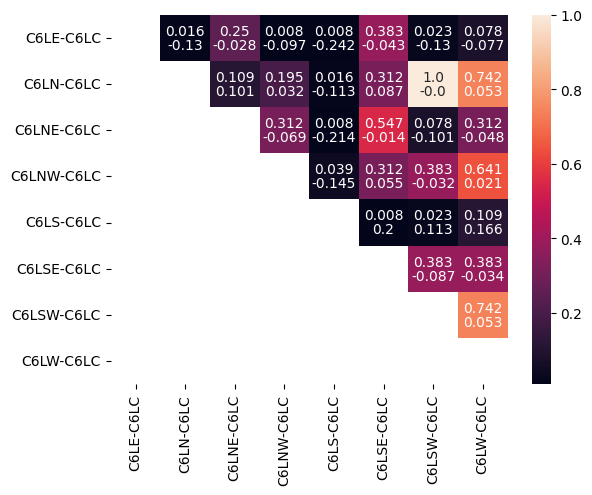

In [51]:
labels = encoder_dict['compound_position'].inverse_transform(radii)

mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [ ]:
def mep_graph(sub,target):
    norm_y = []
    norm_x = []
    subset = sub
    target_position = target

    for subject_ind, subject in enumerate(subjects):
        for m_ind, m in enumerate(muscles):
            # Fix the subject index and size index
            a_temp = a[:, subject_ind, subset, m_ind]
            mean_thres = np.nanmean(a_temp[:,target_position,...],axis=(0))
            curr_params = [
                params[:, subject_ind, subset, m_ind, None] for params in params
            ]

            x_temp = np.array([1.2*mean_thres])[None, None, None, :]

            temp_thresh = F.rectified_logistic(
                x_temp, #x_temp
                *curr_params
            )
            
            # Remove offset
            temp_thresh = temp_thresh - curr_params[2]
            norm_y.append(temp_thresh)
            norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_x = norm_x.reshape(len(subjects), len(muscles),*norm_x.shape[1:])
    norm_y = np.array(norm_y)
    norm_y = norm_y.reshape(len(subjects), len(muscles),*norm_y.shape[1:])
    norm_y = ma.masked_invalid(norm_y)

    y_means = ma.mean(norm_y, axis=(2,4))

    y_diffs = y_means[:,:, :,None] - y_means[:,:,None,:]
    y_diffs = ma.mean(y_diffs, axis=1)

    pvalues = []
    for i in range(len(subset)):
        for i2 in range(len(subset)):
            if i==i2:
                pvalues.append(1)
                continue
            temp_p = stats.wilcoxon(y_diffs[:, i,i2], axis=0).pvalue
            pvalues.append(temp_p)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(subset), len(subset))

    labels = encoder_dict['compound_position'].inverse_transform(subset)

    mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [ ]:
encoder_dict["compound_position"].inverse_transform(vertices)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

In [18]:
a.shape

(4000, 8, 21, 6)

In [83]:
arr = a[:,:,:,:]


In [98]:
a_norm = arr / ma.median(arr, axis=(2,3), keepdims=True)

In [81]:
vertices

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [99]:
a_norm = a_norm[:,:,radii,:]

In [100]:
a_mean = ma.mean(a_norm, axis=0)

In [103]:
a_mean.shape

(8, 8, 6)

In [106]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/L_CIRC/rad_selectivity_means.pkl"

with open(src, "rb") as f:
    sel_rad= pickle.load(f);

In [104]:
a_mean = ma.mean(a_mean, axis = -1)

In [105]:
a_mean.shape

(8, 8)

In [107]:
avg_eff = ma.mean(a_mean, axis=0)
avg_sel = ma.mean(sel_rad, axis=0)

In [108]:
sem_eff = stats.sem(1/a_mean, axis=0)
sem_sel = stats.sem(sel_rad, axis=0)

In [112]:
encoder_dict["compound_position"].inverse_transform(radii)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

In [113]:
1/avg_eff

masked_array(data=[0.8061688248935165, 1.0065275367159092,
                   0.8901760513695369, 0.9514001659012761,
                   1.2743492511237438, 0.8862052557359789,
                   1.0904635801907816, 0.8243640492193536],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [117]:
avg_sel

masked_array(data=[0.8493184170823165, 0.801122898564941,
                   0.8398088152839318, 0.6414490794320726,
                   0.7248068806537595, 0.6581157646367124,
                   0.7855034286478446, 0.6508629596262655],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

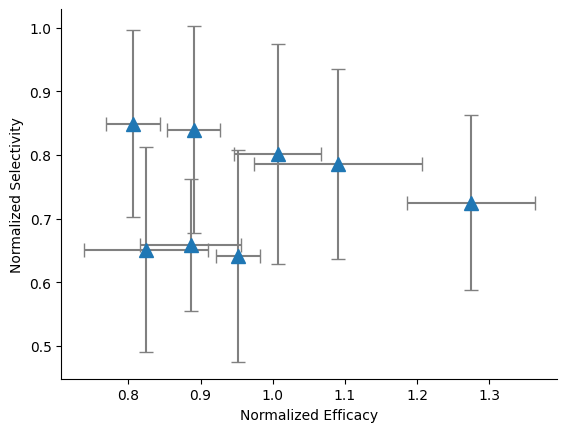

In [109]:
plt.errorbar(x=1/avg_eff, y=avg_sel, yerr=sem_sel, xerr=sem_eff, fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()

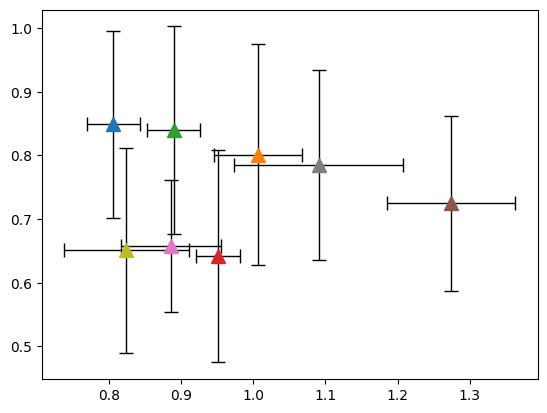

In [116]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x, y, xerr, yerr, colors in zip(1/avg_eff, avg_sel, sem_eff, sem_sel, colors):
    plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='^', ms = 10,ecolor='black', elinewidth=1, capsize=5, color = colors)

In [71]:
a_diff = a_mean[:,:, None,:] - a_mean[:,None,:,:]

In [72]:
a_diff.shape

(8, 4, 4, 6)

In [73]:
a_diff_mean = ma.mean(a_diff, axis=3)

In [74]:
stats.wilcoxon(a_diff_mean[:, 0,1], axis=0)

WilcoxonResult(statistic=0.0, pvalue=0.0078125)

In [75]:
a_diff_mean.shape

(8, 4, 4)

In [76]:
pvalues = []
for i in range(4):
    for i2 in range(4):
        if i==i2:
            pvalues.append(1)
        else:
            pvalues.append(stats.wilcoxon(a_diff_mean[:, i,i2], axis=0).pvalue)

In [77]:
labels = encoder_dict["compound_position"].inverse_transform(diameters)

In [78]:
a_diff_mean.mean(axis=0).data.shape

(4, 4)

In [79]:
pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(diameters), len(diameters))

<Axes: >

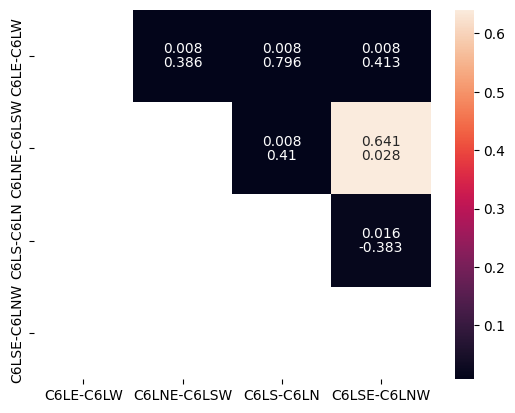

In [80]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(a_diff_mean.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)